# Bike Trips Dataset Exploration
## by Rubén Triviño

## Preliminary Wrangling

We will use a dataset from BayWheels of bike trips. Will explore possible relationships between trips duration, day of the week, hour of the day and number of rides.

We will download dataset of single month csv files and merge them into a single year dataset so we may perform further analysis.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

%matplotlib inline

In [2]:
trip_data = pd.DataFrame();
for year in np.arange(18,19):
    for month in np.arange(1,13):
        monthNumber = "";
        if month < 10:
            monthNumber = "0{}".format(month);
        else:
            monthNumber = str(month);
        monthdf = pd.read_csv("dataset/20{year}{month}-fordgobike-tripdata.csv".format(year=year, month=monthNumber));
        trip_data = trip_data.append(monthdf)

In [3]:
trip_data.to_csv("trip_data.csv", index=False)

### Load Dataset

In [4]:
trip_data = pd.read_csv("trip_data.csv")

In [5]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
 13  bike_share_for_all_trip  object 
dtypes: float64(6), int64(2), object(6)
memory usage: 199.1+ MB


In [7]:
trip_data["start_time"] = pd.to_datetime(trip_data["start_time"])
trip_data["end_time"] = pd.to_datetime(trip_data["end_time"])

### What is the structure of your dataset?

Cada viaje es anónimo e incluye:

* Duración del viaje (segundos)
* Hora y fecha de inicio
* Hora y fecha de finalización
* Identificación de la estación de partida
* Nombre de la estación de partida
* Latitud de la estación de partida
* Longitud de la estación de partida
* Identificación de la estación final
* Nombre de la estación final
* Latitud de la estación final
* Longitud de la estación final
* ID de la bicicleta
* Tipo de usuario (suscriptor o consumidor – “Suscriptor” = Miembro o “Consumidor” = Casual)

### What is/are the main feature(s) of interest in your dataset?

All of the date is of high interest: start date may help us understand if certain day of the week has more higher usage ratio of the bikes or even it may shows a relation between trips duration. In addition, the identification of the main bike stations may show a problem related to the availability of bikes due to the fact that many people start the raid in a station but they drop the bike in a very different one so the company need to replenish the station every certain period of time. Also, ID of bike may help us the how often the same bake is used during his lifetime so we may identify the potencial value that a single bike may generate over its costs. Furthermore, the type of user and it engange to the bike usage overtime may help us understand what type of user we are interested in and what type we should look forward to get more of them, what time it requires to convert a casual consumer into a subscriber and so on...

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

For the porpuse of this study we will be keen on the start datetime of the ride and its duration. Which day of the week has the most number of rides? Is there certain hour of the day that has a spike on rentals? May it be related to the duration of the ride? Shall we expect ride duration given a time?

## Univariate Exploration

### What hour of the way has starting rides?

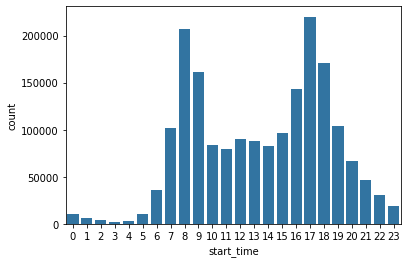

In [60]:
color_palette = sb.color_palette()[0]
sb.countplot(data=trip_data, x=trip_data["start_time"].dt.hour, color=color_palette)

As we can see, the distribuition of these feature seems to be bimodal. This may be due to the hours of heading to work and going back home after work.

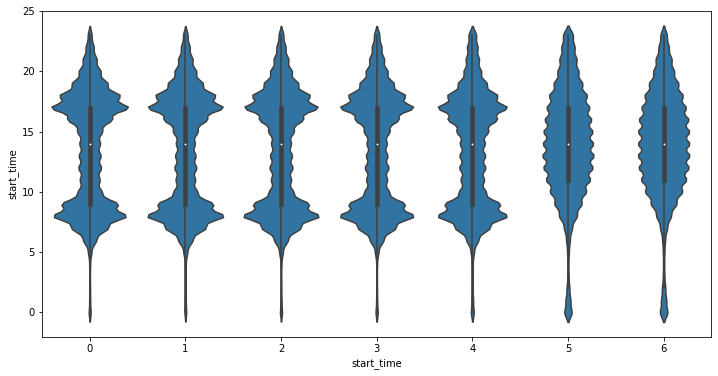

In [61]:
plt.figure(figsize=(12,6))
sb.violinplot(data=trip_data, y=trip_data["start_time"].dt.hour, x=trip_data["start_time"].dt.dayofweek, color=color_palette)

### What is the most frequent ride duration?

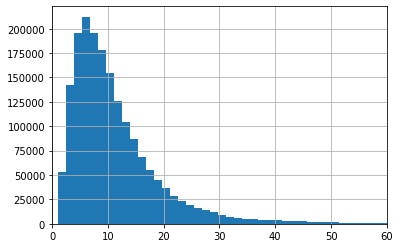

In [52]:
(trip_data["duration_sec"]/60).hist(bins=1000)
plt.xlim(0,60);

In [49]:
(trip_data["duration_sec"]/60).describe()

count    1.863721e+06
mean     1.428838e+01
std      3.950631e+01
min      1.016667e+00
25%      5.833333e+00
50%      9.266667e+00
75%      1.453333e+01
max      1.439433e+03
Name: duration_sec, dtype: float64

In [59]:
round(np.percentile(trip_data["duration_sec"], 95)/60,2)

30.28

We may observe a very skewed distribution. As the more streme values of ride duration do occur frequently enough we should not consider them as outliers. However, they do not represent the mean as the 95% of the rides last less than 30.28 minutes. Those extreme values may be related to people that uses bikes to work as riders of food delivery companies.

### How often a ride comes from a subscriber or a casual consumer?

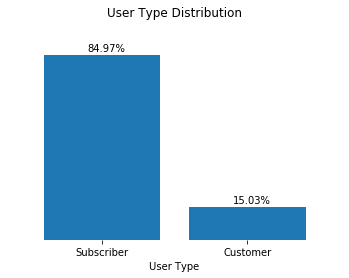

In [167]:
user_type_count = trip_data['user_type'].value_counts(normalize=True).mul(100)
user_type_count.plot(kind="bar", rot=0, width=0.8);
plt.ylim(0,100)
plt.ylabel("% of rides")
plt.xlabel("User Type")
plt.title("User Type Distribution")
for index, ele in enumerate(user_type_count):
    plt.text(-0.1+index,round(ele,2)+2, str(round(ele,2))+"%")
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
ax.set_frame_on(False)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

As we have seen, bike usage distribution seems to be bimodal and share a similar shape during weekdays and it shows a normal distribution on weekends.

Regarding to trips duration, we noticed that there is a small portion of rides that its duration is much langer than the average. As we said, this is not representativa but we cannot consider it as outliers neither so we will trim those values that goes above 30mins long when we show measurements related to trips duration.

Finally, we discovered that subscribers user type are in big majority than casual customer and we will try to find deeper relation ship between these to user types.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

As part of the data wrangling process we converted columns holding datetime values as DateTime type instead of their original type: string.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [168]:
trip_data["start_trip_hour"] = trip_data["start_time"].dt.hour;

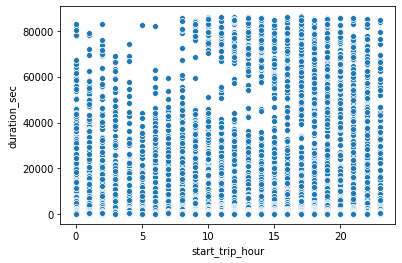

In [171]:
sb.scatterplot(data=trip_data, x="start_trip_hour", y="duration_sec")

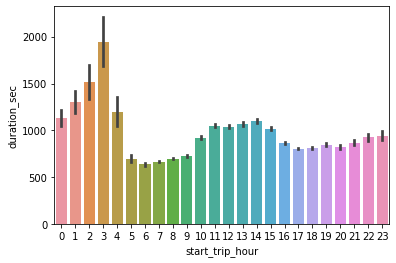

In [172]:
sb.barplot(data=trip_data, x="start_trip_hour", y="duration_sec")

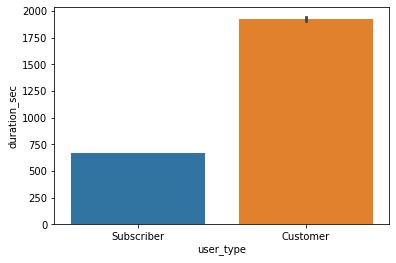

In [174]:
sb.barplot(data=trip_data, y="duration_sec", x="user_type")

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!